In [4]:
using Enzyme, Plots, HDF5, LinearAlgebra, LineSearches, Optim, LaTeXStrings

In [5]:
default(fontfamily="Computer Modern",guidefontsize=16,tickfontsize=13,legendfontsize=13)

In [6]:
mutable struct Lorenz96
    # Model set-up parameters
    N_t::Int64
    dt::Float64
    K::Int64
    F::Float64

    # Model control parameters
    X0::Vector{Float64}
    
    # Variables
    X::Vector{Float64}
    dX::Vector{Float64}
    dXm1::Vector{Float64}
    dXm2::Vector{Float64}
    
    # Data in time array
    X_array::Matrix{Float64}
end

In [7]:
function init_Lorenz96(N_t, dt, K, F, X0)
    # Memory allocation
    X = zeros(Float64, K)
    dX = zeros(Float64, K)
    dXm1 = zeros(Float64, K)
    dXm2 = zeros(Float64, K)
    X_array = zeros(Float64, K, N_t+1)

    # Set intial conditions in X and X_array
    X .= X0
    X_array[:, 1] = X0
    
    # Construct initial L96 object
    L96 = Lorenz96(N_t, dt, K, F, X0, X, dX, dXm1, dXm2, X_array)
    
    return L96
end

init_Lorenz96 (generic function with 1 method)

In [8]:
# dX rhs
function dXrhs(k, X)
    dXk = - X[k - 1] * (X[k - 2] - X[k + 1]) - X[k] + F
    return dXk
end

# Euler step
function euler_step(dt, K, F, X, dX, dXm1, dXm2)
    # Compute derivatives
    dX[1] = - X[K] * (X[K - 1] - X[2]) - X[1] + F
    dX[2] = - X[1] * (X[K] - X[3]) - X[2] + F
    dX[K] = - X[K - 1] * (X[K - 2] - X[1]) - X[K] + F
    
    # Update X
    X[1] += dt * dX[1]
    X[2] += dt * dX[2]
    X[K] += dt * dX[3]
    for k = 3:K-1
        dX[k] = dXrhs(k, X)
        X[k] += dt * dX[k]
    end

    # Update dXs
    dXm1 .= dX
    dXm2 .= dXm1
    
    return X, dX, dXm1, dXm2
end

# AB-3 rhs
function adams_bashforth3(x, dt, dx, dxm1, dxm2)
    rhs = x + dt * ((23/12) * dx 
            - (16/12) * dxm1
            + (5/12) * dxm2)
    return rhs
end

# AB-3 step
function ab3_step(dt, K, F, X, dX, dXm1, dXm2)
    # Compute derivatives
    dX[1] = - X[K] * (X[K - 1] - X[2]) - X[1] + F
    dX[2] = - X[1] * (X[K] - X[3]) - X[2] + F
    dX[K] = - X[K - 1] * (X[K - 2] - X[1]) - X[K] + F
    
    
    # Update X
    X[1] = adams_bashforth3(X[1], dt, dX[1], dXm1[1], dXm2[1])
    X[2] = adams_bashforth3(X[2], dt, dX[2], dXm1[2], dXm2[2])
    X[K] = adams_bashforth3(X[K], dt, dX[K], dXm1[K], dXm2[K])
    for k = 3:K-1
        dX[k] = dXrhs(k, X)
        X[k] = adams_bashforth3(X[k], dt, dX[k], dXm1[k], dXm2[k])
    end

    # Update dXs
    dXm1 .= dX
    dXm2 .= dXm1
    
    return X, dX, dXm1, dXm2
end

ab3_step (generic function with 1 method)

In [9]:
function forward_model(ms)
    for step in 1:2
        euler_step(ms.dt, ms.K, ms.F, ms.X, ms.dX, ms.dXm1, ms.dXm2)
        ms.X_array[:, step+1] = ms.X
    end

    for step in 3:N_t
        ab3_step(ms.dt, ms.K, ms.F, ms.X, ms.dX, ms.dXm1, ms.dXm2)
        ms.X_array[:, step+1] = ms.X
    end
    
    return nothing
end

forward_model (generic function with 1 method)

In [10]:
X0 = [ -4.499888562329307, 2.0277858860974614, 5.625173815733329, 13.766378158617549]

# Model parameters
N_t = 15000
dt = 0.001
ts = range(; start=0, step = dt, length=N_t+1)
K = 4
F = 20.

L96 = init_Lorenz96(N_t, dt, K, F, X0)

forward_model(L96)

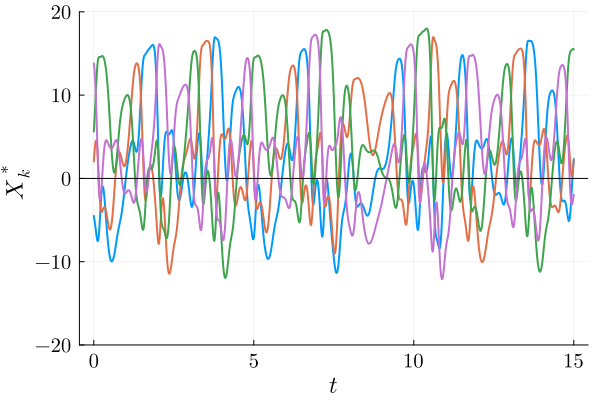

In [11]:
plot(ts, L96.X_array',
    label=[L"$X^\ast_1$" L"$X_2^\ast$" L"$X_3^\ast$" L"$X_4^\ast$"], legend=false, lw=2,
    xlabel=L"$t$", ylabel = L"$X_k^\ast$", ylimits=(-20,20))
hline!([0], color=:black)
# savefig("det_series.png")

In [12]:
mutable struct cost
    # Model set-up parameters
    N_t::Int64
    dt::Float64
    K::Int64
    F::Float64

    # Model observation
    XFO::Vector{Float64}

    # Model control parameters
    X0::Vector{Float64}
    
    # Variables
    X::Vector{Float64}
    dX::Vector{Float64}
    dXm1::Vector{Float64}
    dXm2::Vector{Float64}
    
    # Data in time array
    X_array::Matrix{Float64}
    
    # Objective Function
    J0::Float64
end

In [13]:
function init_cost(N_t, dt, K, F, XFO, X0)
    # Memory allocation
    X = zeros(Float64, K)
    dX = zeros(Float64, K)
    dXm1 = zeros(Float64, K)
    dXm2 = zeros(Float64, K)
    X_array = zeros(Float64, K, N_t+1)

    # Set intial conditions for X, X_array, XFO, J0
    X .= X0
    X_array[:, 1] = X0
    J0 = 0
    
    # Construct initial L96 object
    J0_L96 = cost(N_t, dt, K, F, XFO, X0, X, dX, dXm1, dXm2, X_array, J0)
    
    return J0_L96
end

init_cost (generic function with 1 method)

In [14]:
# function forward_model_cost(N_t, dt, K, F, X, XF, J0)
    
#     cost = init_cost(N_t, dt, K, F, X, XFO, J0)

#     dX = cost.dX
#     dXm1 = cost.dXm1
#     dXm2 = cost.dXm2
#     X_array = cost.X_array
    
#     for step in 1:2
#         euler_step(dt, K, F, X, dX, dXm1, dXm2)
#         X_array[:, step+1] = X
#     end

#     for step in 3:N_t
#         ab3_step(dt, K, F, X, dX, dXm1, dXm2)
#         X_array[:, step+1] = X
#     end

#     J0 = dot(X - XFO, X - XFO)
    
#     return X_array, J0
# end

function J(cost)
    forward_model(cost)

    X = cost.X

    J0 = dot(X - XFO, X - XFO)
    
    return nothing
end



J (generic function with 1 method)

In [15]:
XFO = [2.32, 2.25, 15.48, -1.96] .+ 0.1

X0 = [ -4.5, 2.0, 5.6, 13.8]

# Model parameters
N_t = 15000
dt = 0.001
ts = range(; start=0, step = dt, length=N_t+1)
K = 4
F = 20.
j = init_cost(N_t, dt, K, F, XFO, X0)

cost(15000, 0.001, 4, 20.0, [2.42, 2.35, 15.58, -1.8599999999999999], [-4.5, 2.0, 5.6, 13.8], [-4.5, 2.0, 5.6, 13.8], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-4.5 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; 5.6 0.0 … 0.0 0.0; 13.8 0.0 … 0.0 0.0], 0.0)

In [16]:
function cost_ad!(ms) 
    dms = init_cost(ms.N_t, ms.dt, ms.K, ms.F, ms.XFO, ms.X0)
    Enzyme.autodiff(Reverse, J, Const, Duplicated(ms,dms))
    return dms
end

cost_ad! (generic function with 1 method)

In [ ]:
cost_ad!(j)

In [45]:
Optim.optimize(J, cost_ad!, X0)

LoadError: MethodError: no method matching cost_ad!(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  cost_ad!(::Any) at In[43]:1